# Usage - Python interpreter

To follow this tutorial, it is assumed that MAICoS has been [installed](./installation.rst)
on your computer.

Overview: Only three MAICoS analysis modules are used in this tutorial: [DensityPlanar](../references/modules/density_planar.rst),
[VelocityPlanar](../references/modules/velocity_planar.rst), and
[Diporder](../references/modules/diporder.rst), but all modules follow the same structure:

 <ul>
  <li>a [MDAnalysis](https://userguide.mdanalysis.org/stable/index.html) [AtomGroup](https://userguide.mdanalysis.org/stable/atomgroup.html) must be defined,</li>
  <li>some parameters must be chosen (e.g. ``bin_width``, ``axis``),</li>
  <li>results are stored in the ``results`` object.</li>
</ul> 

Note that some of the calculations may contain pitfall, such as Dielectric profiles calculation. Potential pitfalls and best practices are listed in the ``How-to guides`` section.


## Initialisation

The data test files `slit_flow` of MAICoS are needed.
You can download it by cloning MAICoS repository from Gitlab:

```
    git clone git@gitlab.com:maicos-devel/maicos.git
```

The `slit_flow` data files are located in `tests/data/slit_flow/`. 

Open a new Python script or a new Jupyter Notebook.

First, let us ignore unnecessary warnings by adding:

In [ ]:
import warnings
warnings.filterwarnings("ignore")

Let us import MAICoS, NumPy, MDAnalysis, and Matplotlib:

In [ ]:
import maicos
import numpy as np
import MDAnalysis as mda
import matplotlib.pyplot as plt

Define the path to the ``slit_flow`` data folder of MAICoS (the path may be different,
depending on where your Jupyter Notebook or Python script is located):

In [ ]:
datapath = "../../../tests/data/slit_flow/"

The `slit_flow` system consists of a 2D slab with 1176 water molecules confined
in a 2D slit made of NaCl atoms, where the two water/solid interfaces are normal to 
the axis $z$:

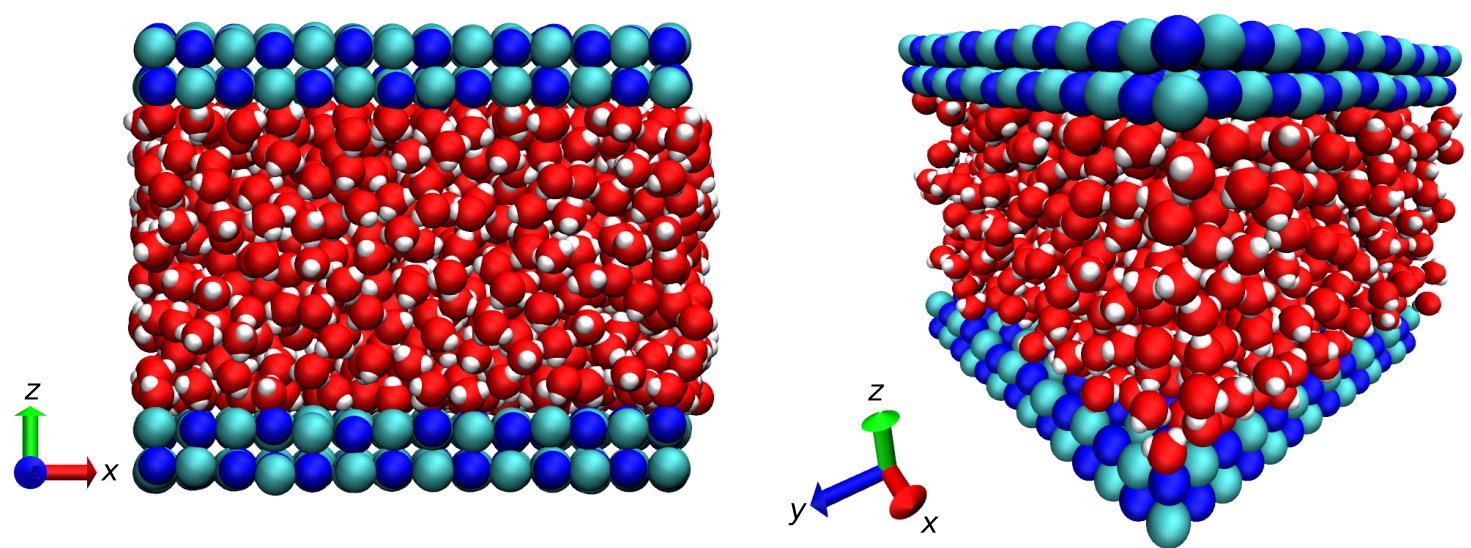

An acceleration $a = 0.05\,\text{nm}\,\text{ps}^{-2}$ is applied to the
water molecules in the $\boldsymbol{e}_x$ direction parallel to the NaCl wall, 
and the atoms of the wall are maintained frozen along $\boldsymbol{e}_x$.

## Create a MDAnalysis universe

Create a universe using MDAnalysis, then define 4 groups, containing respectively:

 <ul>
  <li>the oxygen and the hydrogen atoms of the water molecules,</li>
  <li>the oxygen atoms,</li>
  <li>the hydrogen atoms,</li>
  <li>the Na and Cl atoms of the wall.</li>
</ul> 

In [ ]:
u = mda.Universe(datapath + 'topol.tpr',
                 datapath + 'traj.trr')

group_H2O = u.select_atoms('type OW HW')
group_O = u.select_atoms('type OW')
group_H = u.select_atoms('type HW')
group_NaCl = u.select_atoms('type SOD CLA')

Let us print a few information about the trajectory file:

In [ ]:
print(f"The number of water molecules is {group_O.n_atoms}.")
print(f"The number of NaCl atoms is {group_NaCl.n_atoms}.")

print(f"The total number of frames in the trajectory is {u.trajectory.n_frames}.")
timestep = np.round(u.trajectory.dt, 2)
print(f"The time interval between two frames is {timestep} ps.")
total_time = np.round(u.trajectory.totaltime, 2)
print(f"The total simulation time is {total_time} ps.")

## Extract density profiles using MAICoS

Let us use the ``DensityPlanar`` class of MAICoS to extract the density profile
of the ``group_H2O`` along the (default) $z$ axis by running the analysis:

In [ ]:
dplan = maicos.DensityPlanar(group_H2O).run()

The warning starting with <i>Unwrapping</i> is perfectly normal and can be ignored for now.

Let us extract the coordinate $z$ and the averaged density profile from the ``results`` attribute:

In [ ]:
zcoor = dplan.results.bin_pos
dens = dplan.results.profile_mean

The density profile is given as a 1D array, let us look at the 10 first lines:

In [ ]:
print(dens[:10])

By default the bin_width is 1 Å,and the unit is atomic mass per Ångstrom$^3$ ($\text{amu}/\text{Å}^3$).

Let us plot the density profile using Matplotlib:

In [ ]:
fig, ax = plt.subplots()

ax.plot(zcoor, dens)

ax.set_xlabel(r"z coordinate (Å)")
ax.set_ylabel(r"density H2O (amu / Å$^3$)")

fig.show()

## Improving the results

By changing the value of the default parameters, one can improve the results,
and perform more advanced operations. 

Let us increase the spacial resolution by reducing the bin_width, and extract two profiles instead of one: 
 <ul>
  <li>one for the oxygen atoms of the water molecules,</li>
  <li>one from the hydrogen atoms.</li>
</ul> 

In [ ]:
dplan_smaller_bin = maicos.DensityPlanar([group_O, group_H],
                                         bin_width=0.5,
                                         unwrap=False).run()

zcoor_smaller_bin = dplan_smaller_bin.results.bin_pos
dens_smaller_bin = dplan_smaller_bin.results.profile_mean

In that case, the `dens_smaller_bin` has two columns, one for each group:

In [ ]:
print(dens_smaller_bin[5:15])

Let us plot the results using two differents $y$-axis: 

In [ ]:
fig, ax1 = plt.subplots()

ax1.plot(zcoor_smaller_bin, dens_smaller_bin.T[0], label=r"Oxygen")
ax1.plot(zcoor_smaller_bin, dens_smaller_bin.T[1] * 8, label=r"Hydrogen")

ax1.set_xlabel(r"z coordinate (Å)")
ax1.set_ylabel(r"density O (amu / Å$^3$)")

ax2 = ax1.twinx()
ax2.set_ylabel(r"density H (amu / Å$^3$)]")
ax1.legend()

fig.show()

## Access to all the module's options

For each MAICoS module, they are several parameters similar to `bin_width`.
The parameter list and default options are listed in
the [module's documentation](../modules/density_planar.rst), and can
be gathered by calling the help function of Python:

In [ ]:
help(maicos.DensityPlanar)

Here we can see that for the [module's documentation](../modules/density_planar.rst)
module of MAICoS, there are several possible options such as `zmin`, `zmax` (minimal and 
maximum coordinate to consider), or `refgroup` (to perform the binning with respect to the 
center of mass of a certain group of atoms). 

Knowing this, let us re-calculate the density profile of $\mathrm{H_2O}$,
but this time using the group `group_H2O` as a reference for the center of mass:

In [ ]:
dplan_centered_H2O = maicos.DensityPlanar(group_H2O,
                                          bin_width=0.5,
                                          refgroup=group_H2O,
                                          unwrap=False)
dplan_centered_H2O.run()
zcoor_centered_H2O = dplan_centered_H2O.results.bin_pos
dens_centered_H2O = dplan_centered_H2O.results.profile_mean

Let us also extract the density profile for the NaCl walls, 
but centered with respect to the center of mass of the $\mathrm{H_2O}$ group:

In [ ]:
dplan_centered_NaCl = maicos.DensityPlanar(group_NaCl,
                                           bin_width=0.5,
                                           refgroup=group_H2O,
                                           unwrap=False)
dplan_centered_NaCl.run()
zcoor_centered_NaCl = dplan_centered_NaCl.results.bin_pos
dens_centered_NaCl = dplan_centered_NaCl.results.profile_mean

An plot the two profiles with different $y$-axis:

In [ ]:
fig, ax1 = plt.subplots()

ax1.plot(zcoor_centered_H2O, dens_centered_H2O, label=r"H$_2$O")
ax1.plot(zcoor_centered_NaCl, dens_centered_NaCl / 5, label=r"NaCl")

ax1.set_xlabel(r"z coordinate (Å)")
ax1.set_ylabel(r"density O (amu / Å$^3$)")
ax1.legend()

ax2 = ax1.twinx()
ax2.set_ylabel(r"density NaCl (amu / Å$^3$)")

fig.show()

## Additional options

Use `verbose=True` to display a progress bar:

In [ ]:
dplan_verbose = maicos.DensityPlanar(group_H2O)
dplan_verbose.run(verbose=True)

To analyse only a subpart of a trajectory file, for instance to analyse only
frames 2, 4, 6, 8, and 10, use the `start`, `stop`, and `step` keywords as follow:

In [ ]:
dplan = maicos.DensityPlanar(group_H2O).run(start=10, stop=20, step=2)

## Velocity profile

Here we use the same trajectory file, but extract the velocity profile instead of the density profile. Do to so,
the [VelocityPlanar](../modules/velocity_planar.rst) module is used.

Let us call the velocity module:

In [ ]:
tplan = maicos.VelocityPlanar(group_H2O,
                              bin_width=0.5,
                              vdim=0,
                              flux=False).run()

zcoor = tplan.results.bin_pos
vel = tplan.results.profile_mean

Here the velocity is extracted along the $x$ direction thanks to the ``vdim = 0``
option, but the binning is made 
along the default $z$ axis.

And plot the velocity profile:

In [ ]:
fig, ax = plt.subplots()

ax.plot(zcoor, vel)

ax.set_xlabel(r"z coordinate (Å)")
ax.set_ylabel(r"velocity H2O (Å/ps)")

fig.show()

## Water average orientation

Finally, still using the same trajectory file, we extract the average orientation of the water molecules.

Let us call the [Diporder](../modules/diporder.rst) module to extract the average orientation of the water molecules:

In [ ]:
mydiporder = maicos.Diporder(group_H2O,
                             refgroup=group_H2O,
                             order_parameter="cos_theta").run()

Then, let us extract the cosinus of the angle of the molecules, $\cos(\theta)$:

In [ ]:
zcoor = mydiporder.results.bin_pos
cos_theta = mydiporder.results.profile_mean

In [ ]:
fig, ax = plt.subplots()

ax.plot(zcoor, cos_theta)

ax.set_xlabel(r"z coordinate (Å)")
ax.set_ylabel(r"$\cos (\theta)$")

plt.show()